# Perform DFT

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

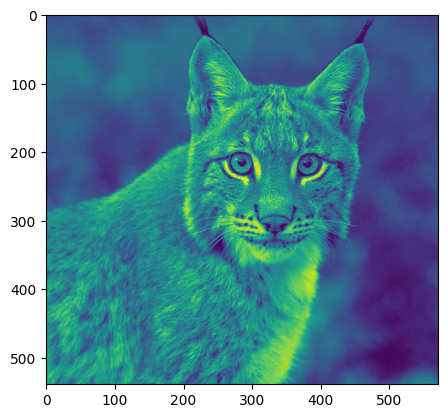

In [46]:
img = cv2.imread("data/lynx.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

In [47]:
img.shape

(539, 572)

In [48]:
import scipy

# scipy.fft is more comprehensive than np.fft
dft = scipy.fft.fft2(img)
magnitude_spectrum = np.abs(dft)
phase_spectrum = np.angle(dft)


_____________
-> What does the 2D DFT do?
- It converts the spatial domain of the image (pixel intensity values) into the frequency domain.
- The frequency domain represents the image as a combination of sinusoidal components, where:
    - Low frequencies correspond to smooth variations in intensity (e.g., overall illumination).
    - High frequencies correspond to rapid changes in intensity (e.g., edges and fine details).


---


- DFT Formula
$$
F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) e^{-j 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$


- Magnitude Formula
$$
\text{Magnitude}(u, v) = |F(u, v)| = \sqrt{\text{Re}(F(u, v))^2 + \text{Im}(F(u, v))^2}
$$
The magnitude represents the strength of the frequency components in the image.
This is what we visualize when observing how much energy (intensity) each frequency contributes to the image.

- Phase spectrum
$$
\text{Phase}(u, v) = \arg(F(u, v)) = \arctan\left(\frac{\text{Im}(F(u, v))}{\text{Re}(F(u, v))}\right)
$$
The phase determines the spatial structure and alignment of the frequency components in the image.

- Inverse 2D Discrete Fourier Transform (IDFT)
$$
f(x, y) = \frac{1}{M N} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} F(u, v) e^{j 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

In [49]:
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum_shifted = np.abs(dft_shift)

In [50]:
magnitude_spectrum_log = np.log1p(magnitude_spectrum)
magnitude_spectrum_shifted_log = np.log1p(magnitude_spectrum_shifted)

Centering the low frequencies in the middle of the spectrum helps visualize the frequency components more intuitively:
- Low frequencies are near the center.
- High frequencies are near the edges.



____
Applying the logarithm compresses the dynamic range of the magnitude spectrum. Without it, large values dominate the visualization, and smaller details become hard to see.In real images, the magnitude spectrum typically has a very high dynamic range. The logarithmic mapping allows us to observe both strong and weak frequency components more clearly.


----
- The DC component in the context of the Discrete Fourier Transform (DFT) refers to the zero-frequency component of the transformed signal or image. It represents the average intensity or the overall energy level of the image. The DC component corresponds to the frequency pair $(u=0,v=0)$ in the Fourier domain.By default, the DC component is located at the top-left corner of the DFT output array.
- The DC component is the frequency component at $f=0$, corresponding to the mean value of the entire signal or image, which does not oscillate.
- After applying fftshift, the DC component is shifted to the center of the frequency spectrum for better visualization. 
- The DC component contains the largest amount of energy in most natural images because most pixel intensities are clustered around the mean value.


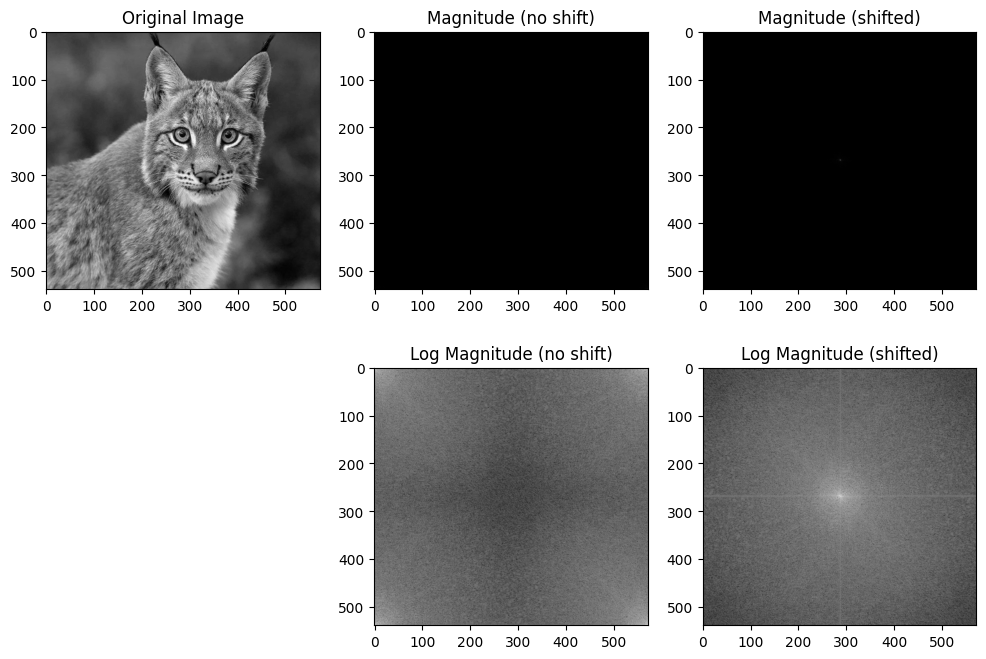

In [51]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1), plt.imshow(img, cmap="gray"), plt.title("Original Image")
plt.subplot(2, 3, 2), plt.imshow(magnitude_spectrum, cmap="gray"), plt.title(
    "Magnitude (no shift)"
)
plt.subplot(2, 3, 3), plt.imshow(magnitude_spectrum_shifted, cmap="gray"), plt.title(
    "Magnitude (shifted)"
)
plt.subplot(2, 3, 5), plt.imshow(magnitude_spectrum_log, cmap="gray"), plt.title(
    "Log Magnitude (no shift)"
)
plt.subplot(2, 3, 6), plt.imshow(
    magnitude_spectrum_shifted_log, cmap="gray"
), plt.title("Log Magnitude (shifted)")
plt.show()

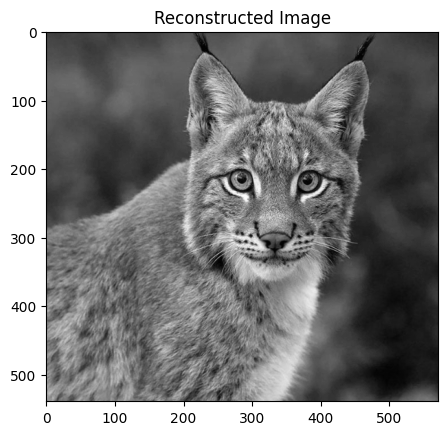

In [52]:
reconstructed_image = np.fft.ifft2(dft).real
plt.imshow(reconstructed_image, cmap="gray")
plt.title("Reconstructed Image")
plt.show()

### Phase

The `np.exp(1j * phase_spectrum)` creates a complex exponential representation:
$$
e^{j\theta} = \cos(\theta) + j\sin(\theta)
$$
This reconstructs a Fourier Transform where all magnitudes are set to 1, leaving only the phase information.


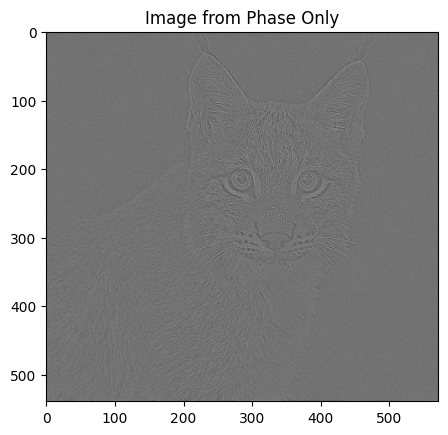

In [53]:
phase_only = np.exp(1j * phase_spectrum)
image_from_phase = np.fft.ifft2(phase_only).real

plt.imshow(image_from_phase, cmap="gray")
plt.title("Image from Phase Only")
plt.show()

### Comment :
Retaining the phase while ignoring the magnitude gives an image that retains the structural features but lacks intensity information

### Magnitude

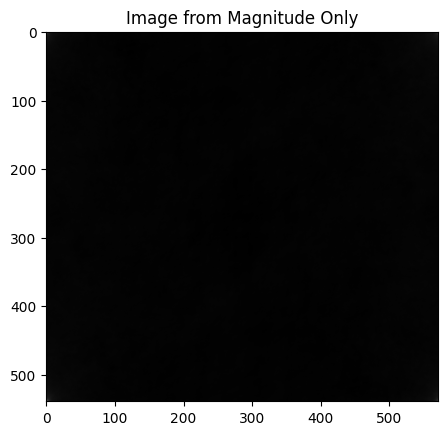

In [63]:
magnitude_only = np.abs(dft)
image_from_magnitude = np.fft.ifft2(magnitude_only).real
plt.imshow(image_from_magnitude, cmap="gray")
plt.title("Image from Magnitude Only")
plt.show()

### Comment : 
We can see we lose structural details about the image, the edges

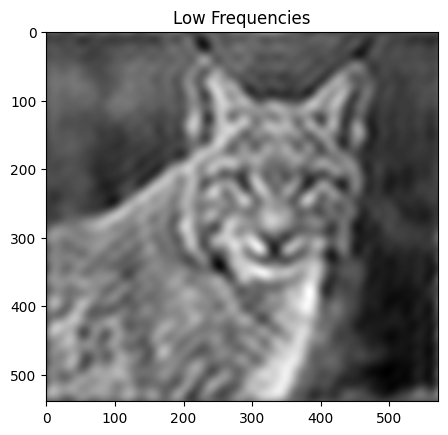

In [65]:
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
# mask for low frequencies
low_pass_mask = np.zeros((rows, cols), np.uint8)
t = 20  # teh size of the sauare low freq region t x t
# the mask isolates low freqs by keeping the values near the center (DC component and surrounding frequencies) while setting the rest to 0.
low_pass_mask[crow - t : crow + t, ccol - t : ccol + t] = 1
# apply the conv mask
low_pass_dft = dft_shift * low_pass_mask
# IDFT
low_pass_image = np.fft.ifft2(np.fft.ifftshift(low_pass_dft)).real
# we apply a low pass filterh equiv to smoothing
plt.imshow(low_pass_image, cmap="gray")
plt.title("Low Frequencies")
plt.show()

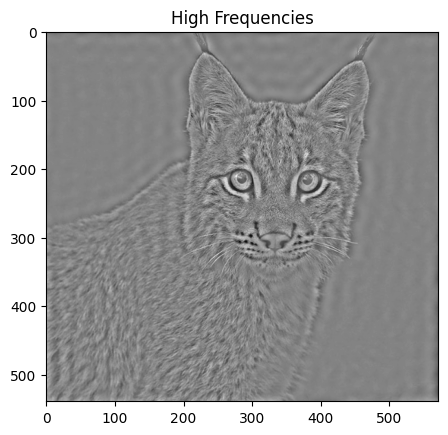

In [ ]:
# mask the high freqs an dapply conv mask
high_pass_mask = 1 - low_pass_mask
high_pass_dft = dft_shift * high_pass_mask
# IDFT
high_pass_image = np.fft.ifft2(np.fft.ifftshift(high_pass_dft)).real
plt.imshow(high_pass_image, cmap="gray")
plt.title("High Frequencies")
plt.show()

High frequencies are associated with fine details, sharp edges, and high-contrast features in the image. After applying this mask, all smooth structures are removed, leaving only fine details.

### Comments : 
- **Phase-only Reconstruction**: The phase carries the structural information of the image, so the phase-only image might resemble the original image but with reduced intensity.
- **Magnitude-only Reconstruction**: The magnitude contains the energy distribution; the image reconstructed from only the magnitude will lose structural details.
- **Low Frequencies**: Keeping only low frequencies results in a blurry version of the image, as fine details (high frequencies) are removed.
- **High Frequencies**: Keeping only high frequencies results in an edge-detected appearance, as low-frequency background is suppressed.